# Problem 3

In [887]:
# requirements
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

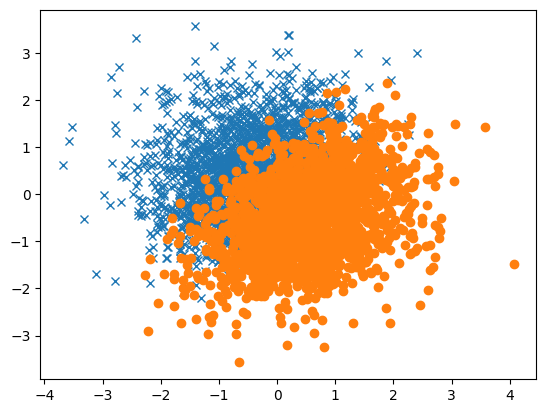

In [888]:
# dataset 2
np.random.seed(123)
n = 4000
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)

x_d2 = np.random.randn(n, 2) + 0
y_d2 = 2 * (omega * x_d2[:,0] + x_d2[:,1] + noise > 0) - 1

plt.plot(np.extract(y_d2>0,x_d2[:,0]),np.extract(y_d2>0,x_d2[:,1]), 'x')
plt.plot(np.extract(y_d2<0,x_d2[:,0]),np.extract(y_d2<0,x_d2[:,1]), 'o')

In [889]:
# Use dataset 2
X = x_d2  # Use the dataset 2 data
y = y_d2  # Use the dataset 2 labels

# Take a subset for computational efficiency
subset_size = 200
np.random.seed(42)  # For reproducibility
indices = np.random.choice(n, subset_size, replace=False)
X = X[indices]
y = y[indices]
n = subset_size

In [890]:
# Compute the kernel matrix K where K[i,j] = y_i * y_j * x_i^T * x_j
def compute_kernel_matrix(X, y):
    n = len(y)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = y[i] * y[j] * np.dot(X[i], X[j])
    return K

# Compute kernel matrix
K = compute_kernel_matrix(X, y)

# Define dual objective function
def dual_objective(alpha, K, lambda_reg):
    return -1/(2*lambda_reg) * alpha.T @ K @ alpha + np.sum(alpha)

# Define primal objective function
def primal_objective(w, X, y, lambda_reg):
    hinge_losses = np.maximum(0, 1 - y * (X @ w))
    return np.sum(hinge_losses) + lambda_reg/2 * np.dot(w, w)

# Projection operator onto [0, 1]
def project_box(alpha):
    return np.clip(alpha, 0, 1)

In [891]:
# Compute optimal weight w from dual variables α using KKT condition
def compute_w_from_alpha(alpha, X, y, lambda_reg):
    w = np.zeros(X.shape[1])
    for i in range(len(alpha)):
        w += alpha[i] * y[i] * X[i]
    w /= lambda_reg
    return w

In [892]:
#Projected Gradient Method Implementation
def compute_dual_gradient(alpha, K, lambda_reg):
    return (1/lambda_reg) * K @ alpha - np.ones(len(alpha))

def projected_gradient_descent(X, y, K, lambda_reg, max_iter, learning_rate, tol):
    n = len(y)
    alpha = np.zeros(n)  # Initialize

    dual_values = []
    primal_values = []
    duality_gaps = []
    iterations = []

    for t in range(max_iter):
        # Compute gradient
        grad = compute_dual_gradient(alpha, K, lambda_reg)

        # Adaptive learning rate
        current_lr = learning_rate / np.sqrt(1 + t)

        # Gradient step
        alpha_new = alpha - current_lr * grad

        # Projection step
        alpha = project_box(alpha_new)

        # Compute w from current α
        w = compute_w_from_alpha(alpha, X, y, lambda_reg)

        # Compute objective values
        dual_val = dual_objective(alpha, K, lambda_reg)
        primal_val = primal_objective(w, X, y, lambda_reg)
        duality_gap = primal_val - dual_val

        dual_values.append(dual_val)
        primal_values.append(primal_val)
        duality_gaps.append(duality_gap)
        iterations.append(t)

        if duality_gap < tol:
            print(f"Converged at iteration {t} with duality gap: {duality_gap:.6f}")
            break

    return alpha, w, dual_values, primal_values, duality_gaps, iterations

# Set regularization parameter
lambda_reg = 10

# Run projected gradient descent
alpha_opt, w_opt, dual_vals, primal_vals, gaps, iters = projected_gradient_descent(
    X, y, K, lambda_reg, max_iter=5000, learning_rate=0.05, tol=1e-6
)

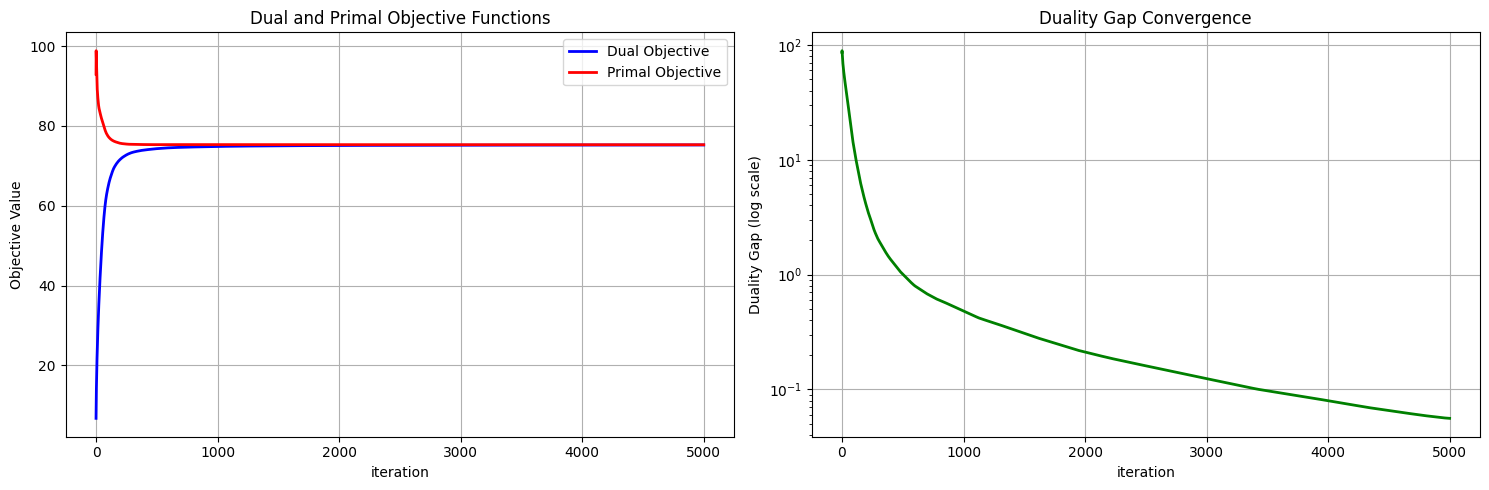

In [893]:
# Visualize convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot dual and primal objectives
ax1.plot(iters, dual_vals, 'b-', label='Dual Objective', linewidth=2)
ax1.plot(iters, primal_vals, 'r-', label='Primal Objective', linewidth=2)
ax1.set_xlabel('iteration')
ax1.set_ylabel('Objective Value')
ax1.set_title('Dual and Primal Objective Functions')
ax1.legend()
ax1.grid(True)

# Plot duality gap
ax2.semilogy(iters, gaps, 'g-', linewidth=2)
ax2.set_xlabel('iteration')
ax2.set_ylabel('Duality Gap (log scale)')
ax2.set_title('Duality Gap Convergence')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [894]:
# Subgradient Method Implementation
def compute_subgradient(w, X, y, lambda_reg):
    n = len(y)
    subgrad_w = lambda_reg * w # Regularization term

    # Add subgradient of hinge loss
    for i in range(n):
        margin = y[i] * np.dot(X[i], w)
        if margin < 1:
            subgrad_w -= y[i] * X[i]

    return subgrad_w

def subgradient_method(X, y, lambda_reg, max_iter, learning_rate, tol):
    d = X.shape[1]
    w = np.random.randn(d) * 0.01  # Initialize

    primal_objectives = []
    iterations_sub = []

    for t in range(max_iter):
        # Compute subgradient
        subgrad = compute_subgradient(w, X, y, lambda_reg)

        # Using adapted learning rate
        lr = learning_rate / np.sqrt(1 + t)
        w -= lr * subgrad

        # Compute objective value
        obj_val = primal_objective(w, X, y, lambda_reg)

        primal_objectives.append(obj_val)
        iterations_sub.append(t)
        if t > 0 and abs(primal_objectives[-2] - primal_objectives[-1]) < tol:
            print(f"Converged at iteration {t} with objective value: {obj_val:.6f}")
            break

    return w, primal_objectives, iterations_sub

# Run subgradient method
w_subgrad, primal_objs_sub, iters_sub = subgradient_method(
    X, y, lambda_reg, max_iter=50, learning_rate=0.04, tol=1e-6
)

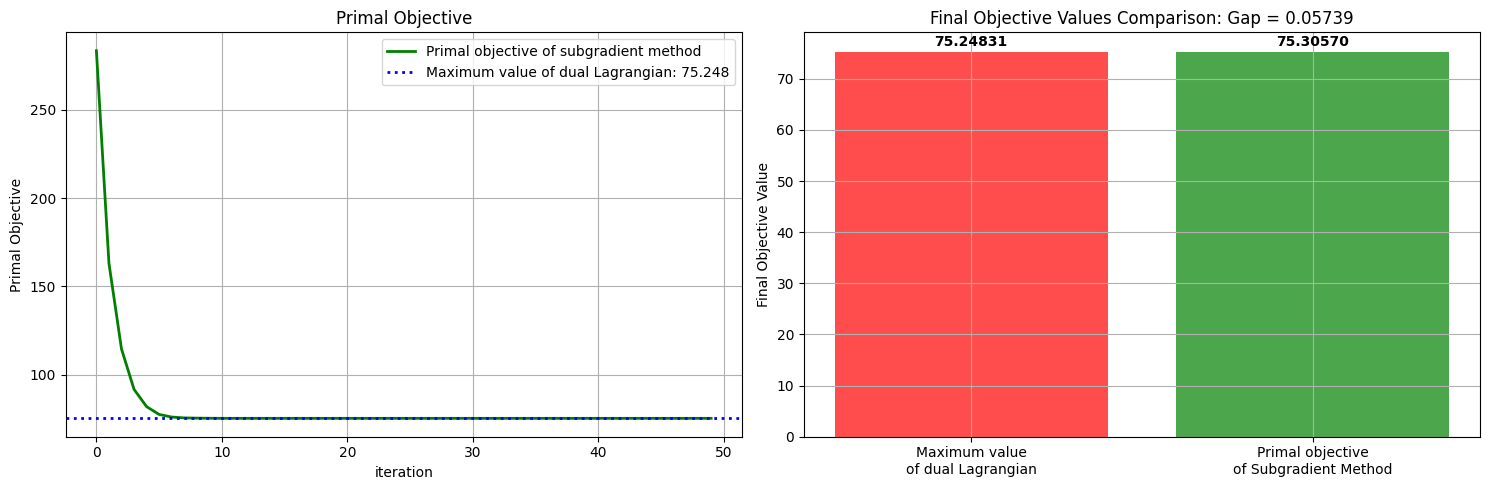

In [895]:
# Comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot primal objective comparison
ax1.plot(iters_sub, primal_objs_sub, 'g-', linewidth=2, label='Primal objective of subgradient method')
ax1.axhline(y=dual_vals[-1], color='b', linestyle=':', linewidth=2, label=f'Maximum value of dual Lagrangian: {dual_vals[-1]:.3f}')
ax1.set_xlabel('iteration')
ax1.set_ylabel('Primal Objective')
ax1.set_title('Primal Objective' )
ax1.legend()
ax1.grid(True)

# Show final convergence values comparison
methods = ['Maximum value\nof dual Lagrangian', 'Primal objective\nof Subgradient Method']
objectives = [ dual_vals[-1], primal_objs_sub[-1]]
colors = ['red', 'green']

bars = ax2.bar(methods, objectives, color=colors, alpha=0.7)
ax2.set_ylabel('Final Objective Value')
ax2.set_title(f'Final Objective Values Comparison: Gap = {primal_objs_sub[-1]-dual_vals[-1]:.5f}')
ax2.grid(True)

# Add value labels on bars
for bar, obj in zip(bars, objectives):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{obj:.5f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()